# How to Build a Session-based Recommender using Word2vec
> A key trend over the past few years has been session-based recommendation algorithms that provide recommendations solely based on a user’s interactions in an ongoing session, and which do not require the existence of user profiles or their entire historical preferences. This tutorial explores a simple, yet powerful, NLP-based approach (word2vec) to recommend a next item to a user. While NLP-based approaches are generally employed for linguistic tasks, here we exploit them to learn the structure induced by a user’s behavior or an item’s nature.

- toc: true
- badges: false
- comments: true
- categories: [Session, Sequential, Retail, Word2vec]
- image:

## Introduction

Duration: 5

A user’s choice of items not only depends on long-term historical preference, but also on short-term and more recent preferences. Choices almost always have time-sensitive context; for instance, “recently viewed” or “recently purchased” items may actually be more relevant than others. These short-term preferences are embedded in the user’s most recent interactions, but may account for only a small proportion of historical interactions. In addition, a user’s preference towards certain items can tend to be dynamic rather than static; it often evolves over time.

A key trend over the past few years has been session-based recommendation algorithms that provide recommendations solely based on a user’s interactions in an ongoing session, and which do not require the existence of user profiles or their entire historical preferences. This tutorial explores a simple, yet powerful, NLP-based approach (word2vec) to recommend a next item to a user. While NLP-based approaches are generally employed for linguistic tasks, here we exploit them to learn the structure induced by a user’s behavior or an item’s nature.

### What you'll learn?

1. How to preprocess retail transactional data for sequential recommender modeling
2. How to use word2vec to train session-based recommender
3. How to use Ray to optimize hyperparameters

### Why is this important?

1. Session-based recommendation is an important class and a must-to-know process

### How it will work?

To train a model for this task, we’ll need to use historical browsing sessions from our other existing users to identify trends between products that will help us learn recommendations.


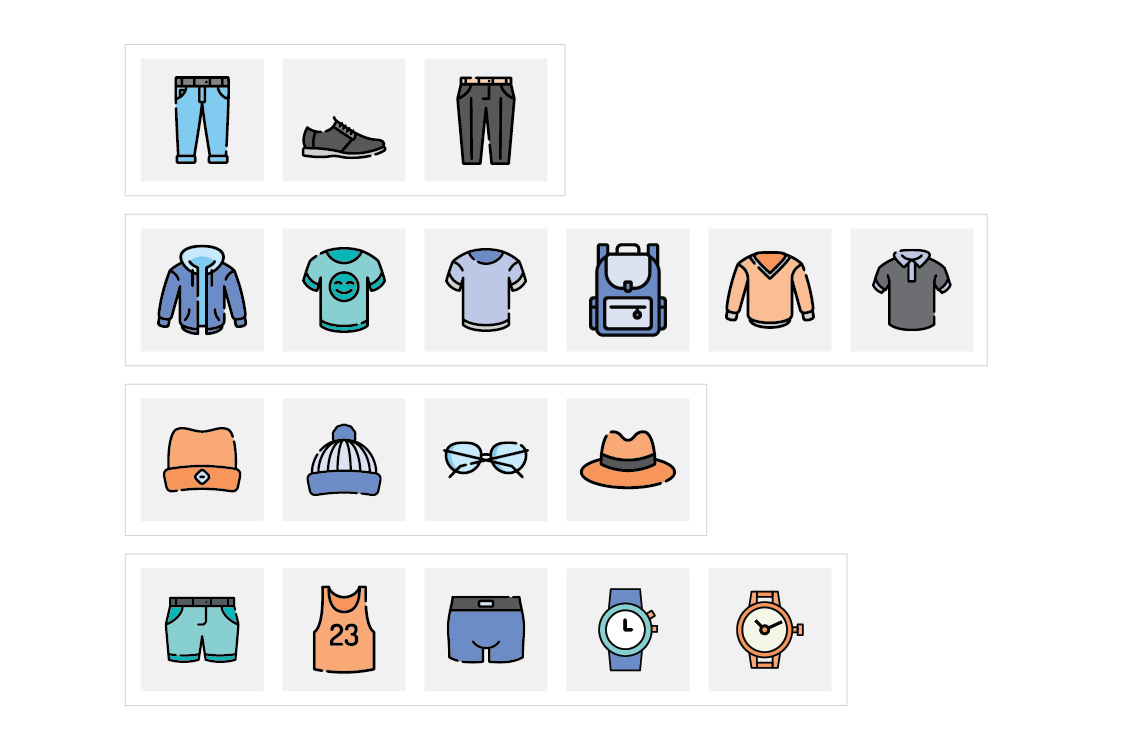

We will first load the data and preprocess it to create sessions. We will save this preprocessed data as a pickle file. Then we will train  word2vec model using this dataset and then find the best hyperparameters of this word2vec model using Ray tune.

### Who is this for?

- People who are new in deep learning and sequential modeling
- People looking to build a session-based recommender system

### Important resources

- [Colab notebook](https://github.com/recohut-admin/reco-nb/blob/dev/_notebooks/2021-06-11-recostep-session-based-recommender-using-word2vec.ipynb)

<!---------------------------->

## Definition

Duration: 5

### What is a session?

Formally, a session is composed of multiple user interactions that happen together in a continuous period of time—for instance, products purchased in a single transaction. Sessions can occur on the same day, or across several days, weeks, or months.


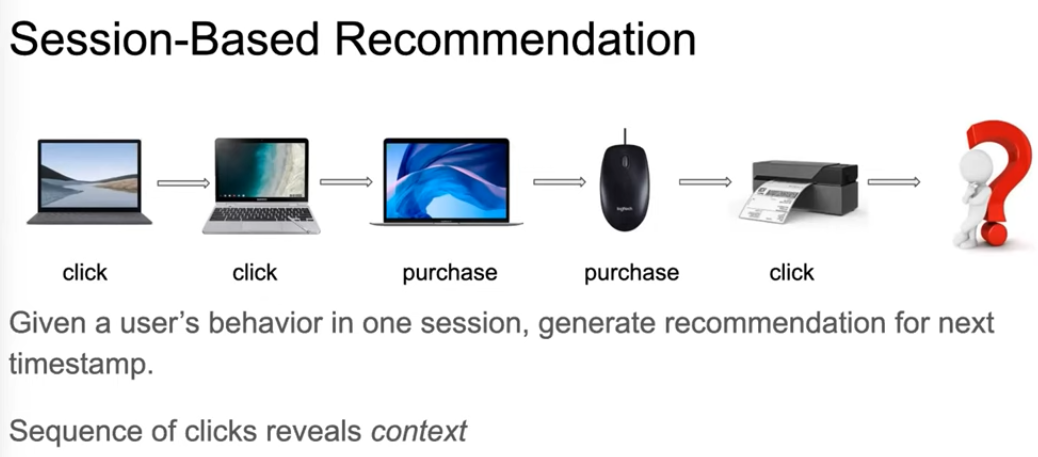

### Session-based recommendations

Session-based recommendation tasks are performed based on the user's anonymous historical behavior sequence and implicit feedback data, such as clicks, browsing, purchasing, etc., rather than rating or comment data. The primary aim is to predict the next behavior based on a sequence of the historical sequence of the session. Session-based recommendation aims to predict which item a user will click next, solely based on the user’s current sequential session data without access to the long-term preference profile.

The input to these systems are time-ordered logs of recorded user interactions, where the interactions are grouped into sessions. Such a session could, for example, correspond to a listening session on a music service, or a shopping session on an e-commerce site. One particularity of such approaches is that users are anonymous, which is a common problem on websites that deal with first-time users or users that are not logged in. The prediction task in this setting is to predict the next user action, given only the interactions of the ongoing session. Today, session-based recommendation is a highly active research area due to its practical relevance.

Markov chains is a classic case, which assumes that the next action is based on the previous ones. Many sequential recommendation methods based on the Markov chain (MC) model predict the next item based on the previous one through computing transition probabilities between two consecutive items. FPMC models the sequence behavior between every two adjacent clicks and provides a more accurate prediction for each sequence by factoring the user's personalized probability transfer matrix. The main problem with Markov methods, however, is that they assume too strongly the independence of more than two consecutive actions, so a great number of important sequential information cannot be well exploited for sessions with more than two actions.


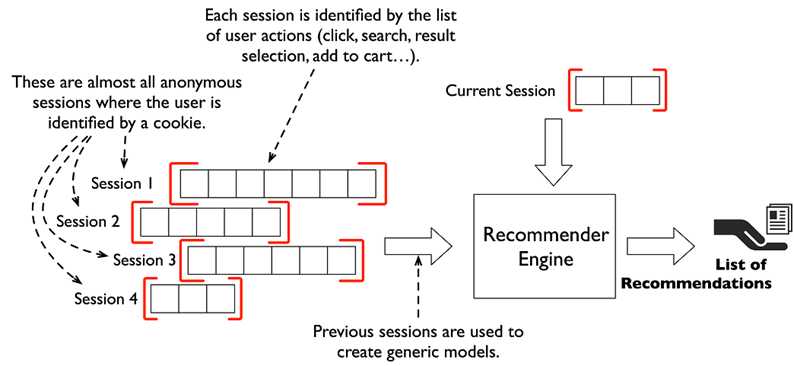

A session is a chunk of interactions that take place within a given time frame. It may span a single day, or several days, weeks, or even months. A session usually has a time-limited goal, such as finding a restaurant for dinner tonight, listening to music of a certain style or mood, or looking for a location for one’s next holiday.


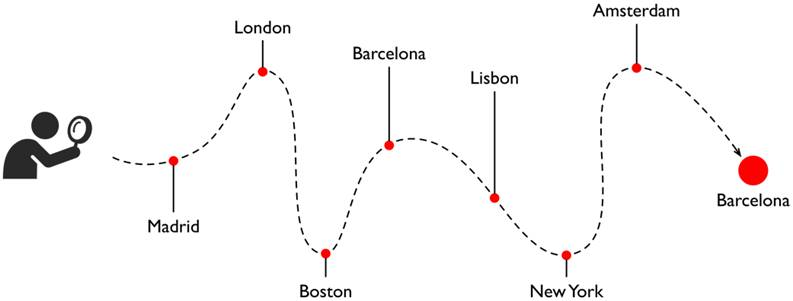

### Next event prediction (NEP)

Given a series of events (e.g. user's browsing history), the task is to predict the next event.

<!---------------------------->

## Data

Duration: 5

We chose an open domain e-commerce dataset from a UK-based online boutique selling specialty gifts. This dataset was collected between 12/01/2010 and 12/09/2011 and contains purchase histories for 4,372 customers and 3,684 unique products. These purchase histories record transactions for each customer and detail the items that were purchased in each transaction. This is a bit different from a browsing history, as it does not contain the order of items clicked while perusing the website; it only includes the items that were eventually purchased in each transaction. However, the transactions are ordered in time, so we can treat a customer’s full transaction history as a session. Instead of predicting recommendations for what a customer might click on next, we’ll be predicting recommendations for what that customer might actually buy next. Session definitions are flexible, and care must be taken in order to properly interpret the results.

The dataset is composed of the following columns:

- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides.

### Snapshot


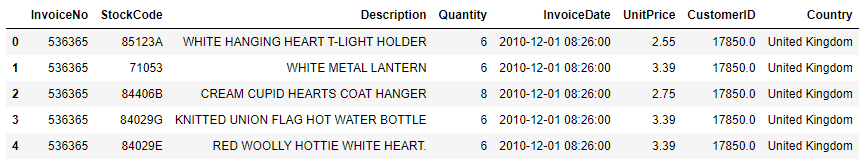

## EDA

Duration: 10

### Session length

We define a session as a customer’s full purchase history (all items purchased in each transaction) over the life of the dataset. Below, we show a boxplot of the session lengths (how many items were purchased by each customer). The median customer purchased 44 products over the course of the dataset, while the average customer purchased 96 products.


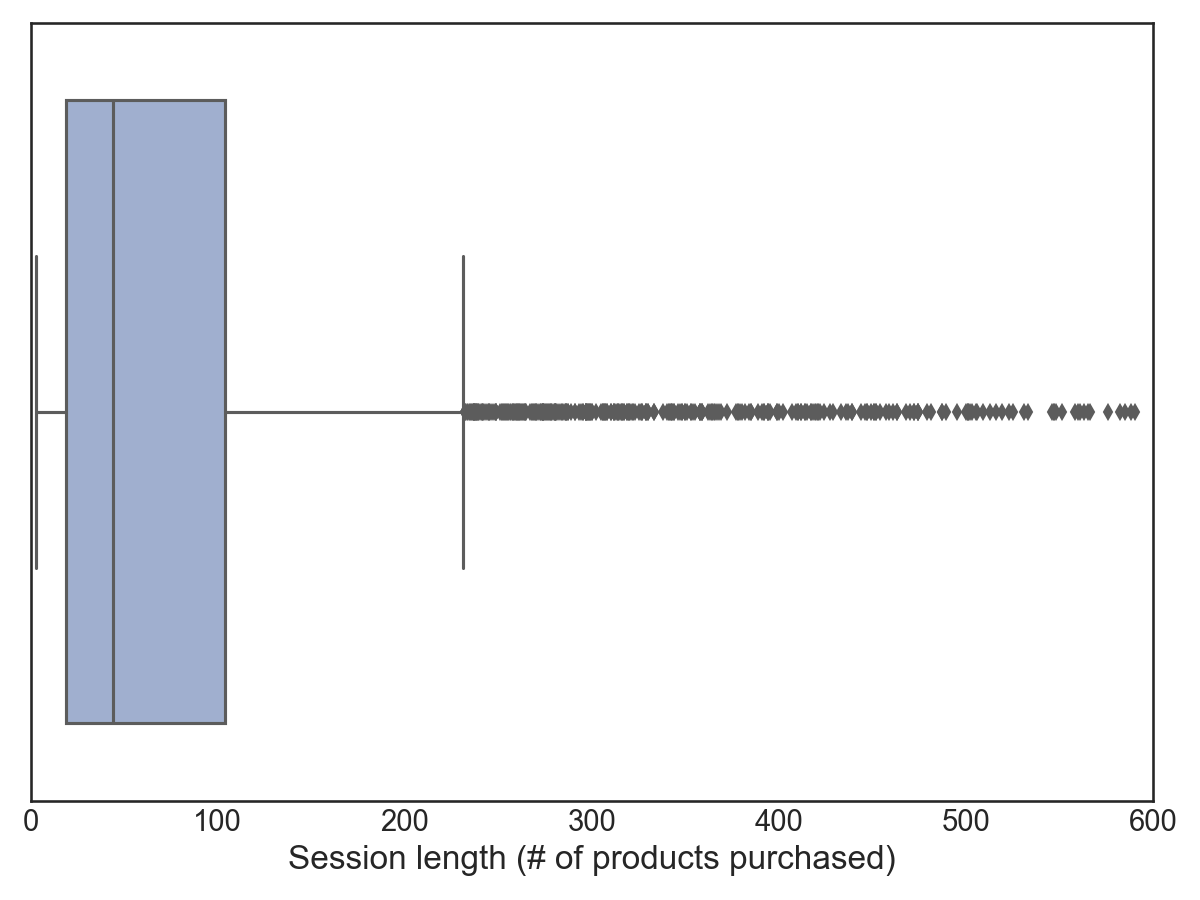

### Product popularity

Another thing to note is the popularity of individual products. Below, we show the log counts of how often each product was purchased. Most products are not very popular and are only purchased a handful of times. On the other hand, a few products are wildly popular and purchased thousands of times.


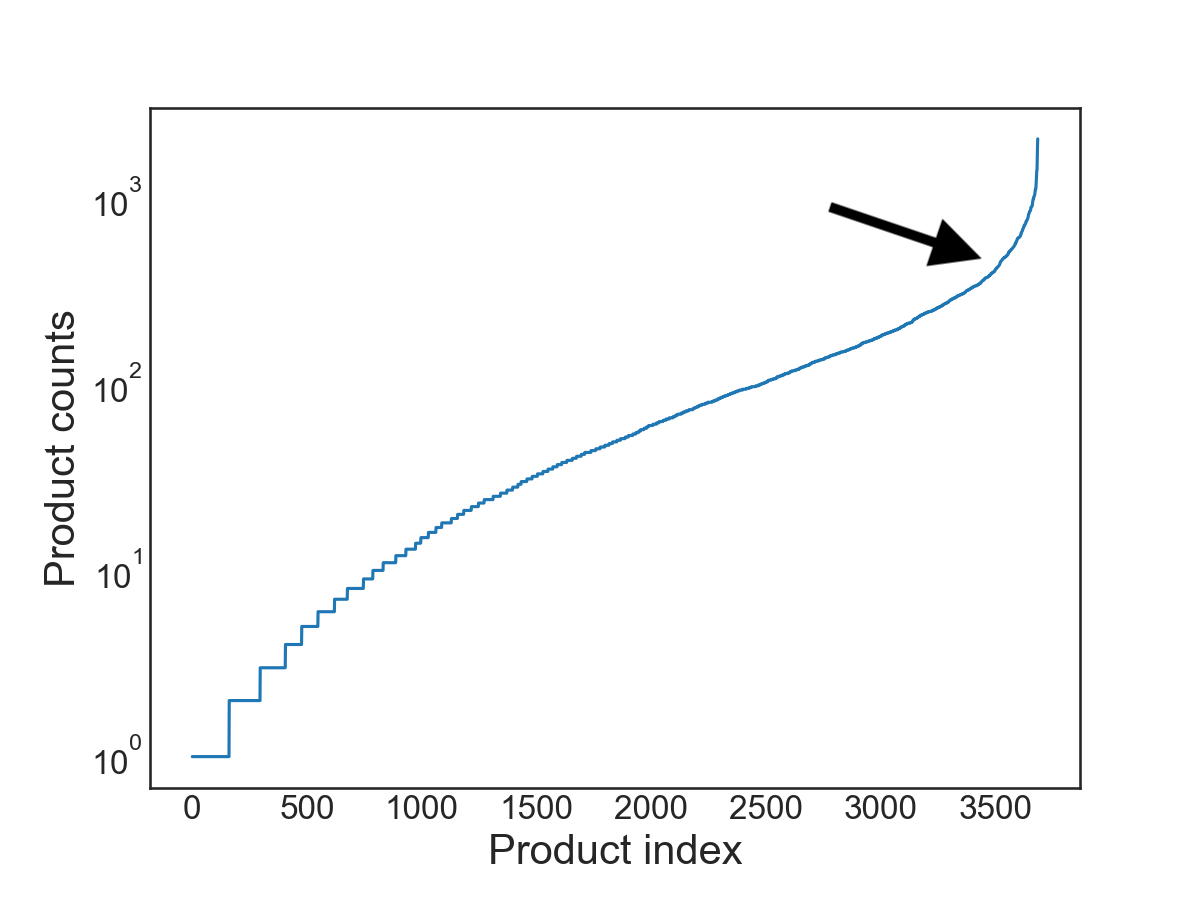

## Preprocessing

Duration: 10

### Pre-filtering

- Personally identifying information has already been removed
- We removed entries that did not contain a customer ID number (which is how we define a session)
- We removed sessions that contain fewer than three purchased items. A session with only two, for instance, is just a [query item, ground truth item] pair and does not give us any examples for training

```python
def preprocess_ecomm(df, min_session_count=3):

    df.dropna(inplace=True)
    item_counts = df.groupby(["CustomerID"]).count()["StockCode"]
    df = df[df["CustomerID"].isin(item_counts[item_counts >= min_session_count].index)].reset_index(drop=True)
    
    return df
```

### Sequential revealing strategy

The effectiveness of an algorithm is measured by its ability to predict items withheld from the session. There are a variety of withholding strategies:

- withholding the last element of each session
- iteratively revealing each interaction in a session
- in cases where each user has multiple sessions, withholding the entire final session

In this tutorial, we have employed withholding the last element of the session.

```python
def construct_session_sequences(df, sessionID, itemID, save_filename):
    """
    Given a dataset in pandas df format, construct a list of lists where each sublist
    represents the interactions relevant to a specific session, for each sessionID. 
    These sublists are composed of a series of itemIDs (str) and are the core training 
    data used in the Word2Vec algorithm. 
    This is performed by first grouping over the SessionID column, then casting to list
    each group's series of values in the ItemID column. 
    INPUTS
    ------------
    df:                 pandas dataframe
    sessionID: str      column name in the df that represents invididual sessions
    itemID: str         column name in the df that represents the items within a session
    save_filename: str  output filename 
  
    Example:
    Given a df that looks like 
    SessionID |   ItemID 
    ----------------------
        1     |     111
        1     |     123
        1     |     345
        2     |     045 
        2     |     334
        2     |     342
        2     |     8970
        2     |     345
    
    Retrun a list of lists like this: 
    sessions = [
            ['111', '123', '345'],
            ['045', '334', '342', '8970', '345'],
        ]
    """
    grp_by_session = df.groupby([sessionID])

    session_sequences = []
    for name, group in grp_by_session:
        session_sequences.append(list(group[itemID].values))

    pickle.dump(session_sequences, open(save_filename, "wb"))
    return session_sequences
```

### Splitting


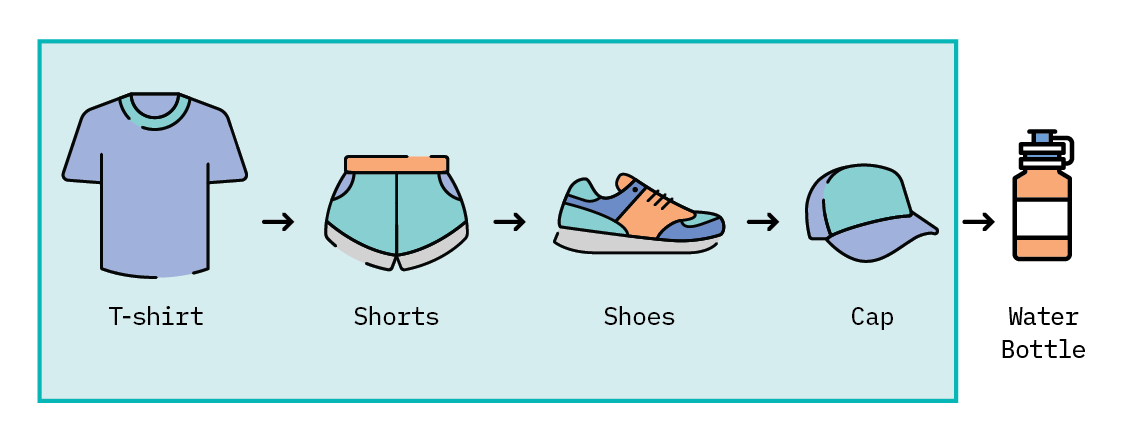

wherein the first n-1 items highlighted in a green box act as part of the training set, while the item outside is used as ground truth for the recommendations generated.

For each customer in the Online Retail Data Set, we construct the training set from the first n-1 purchased items. We construct test and validation sets as a series of [query item, ground truth item] pairs. The test and validation sets must be disjoint—that is, each set is composed of pairs with no pairs shared between the two sets (or else we would leak information from our validation into the final test set!).

```python
def train_test_split(session_sequences, test_size: int = 10000, rng=rng):
    """
    Next Event Prediction (NEP) does not necessarily follow the traditional train/test split. 
    Instead training is perform on the first n-1 items in a session sequence of n items. 
    The test set is constructed of (n-1, n) "query" pairs where the n-1 item is used to generate 
    recommendation predictions and it is checked whether the nth item is included in those recommendations. 
    Example:
        Given a session sequence ['045', '334', '342', '8970', '128']
        Training is done on ['045', '334', '342', '8970']
        Testing (and validation) is done on ['8970', '128']
    
    Test and Validation sets are constructed to be disjoint. 
    """

    ## Construct training set
    # use (1 st, ..., n-1 th) items from each session sequence to form the train set (drop last item)
    train = [sess[:-1] for sess in session_sequences]

    if test_size > len(train):
        print(
            f"Test set cannot be larger than train set. Train set contains {len(train)} sessions."
        )
        return

    ### Construct test and validation sets
    # sub-sample 10k sessions, and use (n-1 th, n th) pairs of items from session_squences to form the
    # disjoint validaton and test sets
    test_validation = [sess[-2:] for sess in session_sequences]
    index = np.random.choice(range(len(test_validation)), test_size * 2, replace=False)
    test = np.array(test_validation)[index[:test_size]].tolist()
    validation = np.array(test_validation)[index[test_size:]].tolist()

    return train, test, validation
```

<!---------------------------->

## Problem design

Duration: 5

Given a query item, we’ll generate a handful of recommendations that are the most similar to that item, using cosine similarity. This is the same technique we would use if we wanted to find similar words. Instead of semantic similarity between words, we hope we have learned embeddings that capture the semantic similarity between product IDs that users purchased.


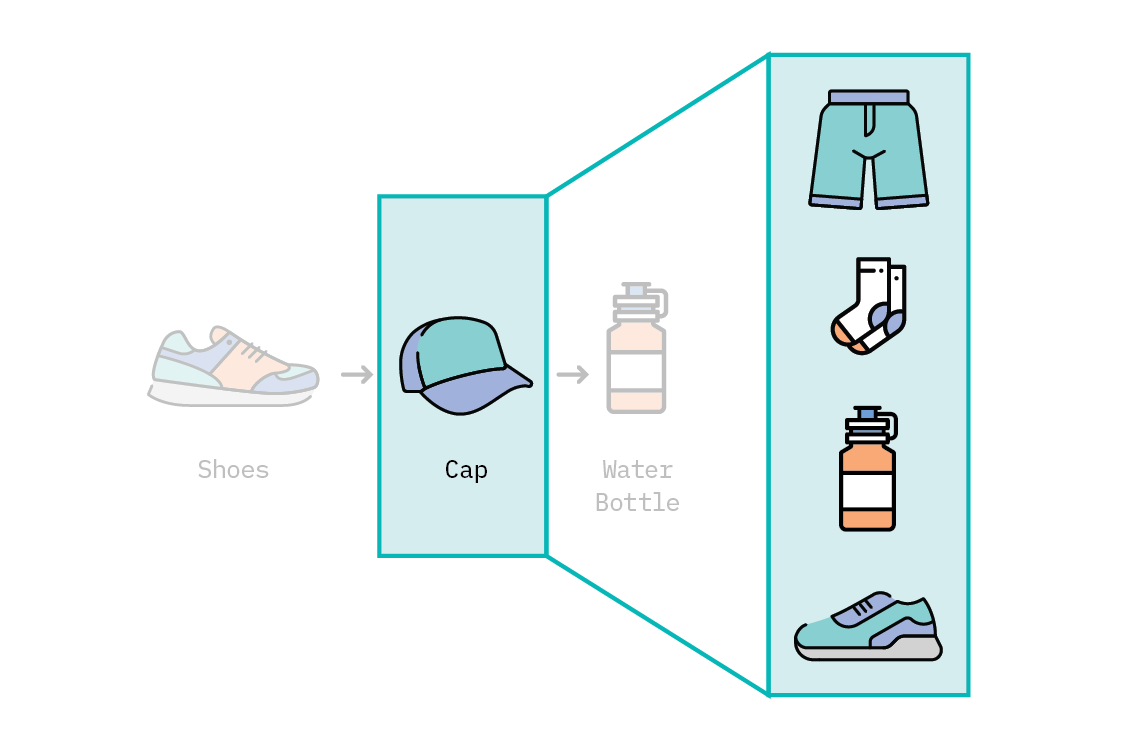

The query item (the last item in a training sequence) is used to generate K product recommendations

Armed with a list of recommendations, we can now score our model by checking whether the corresponding ground truth item is in our list of recommendations.

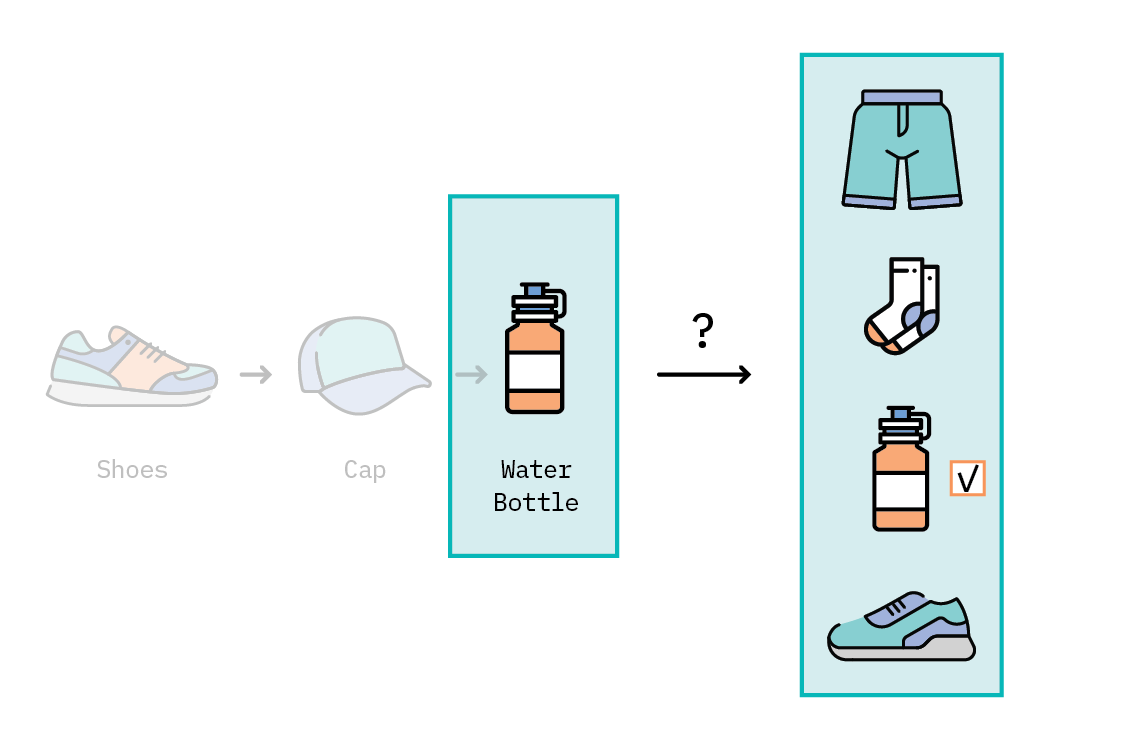

We’ll perform this set of operations for each [query item, ground truth item] pair in our test set, to compute an overall score using Recall@K and MRR@K.

<!---------------------------->

## Model

Duration: 10

There are many baselines for the next event prediction (NEP) task. The simplest and most common are designed to recommend the item that most frequently co-occurs with the last item in the session. Known as “Association Rules,” this heuristic is straightforward, but doesn’t capture the complexity of the user’s session history.

```python
def association_rules_baseline(train_sessions):
    """
    Constructs a co-occurence matrix that counts how frequently each item 
    co-occurs with any other item in a given session. This matrix can 
    then be used to generate a list of recommendations according to the most
    frequently co-occurring items for the item in question. 

    These recommendations must be evaluated using the "_baseline"  recall/mrr functions in metrics.py
    """
    comatrix = collections.defaultdict(list)
    for session in train_sessions:
        for (x, y) in itertools.permutations(session, 2):
            comatrix[x].append(y)
    return comatrix
```

More recently, deep learning approaches have begun to make waves. Variations of graph neural networks and recurrent neural networks have been applied to the problem with promising results, and currently represent the state of the art in NEP for several use cases. However, while these algorithms capture complexity, they can also be difficult to understand, unintuitive in their recommendations, and not *always* better than comparably simple algorithms (in terms of prediction accuracy).

There is still another option, though, that sits between simple heuristics and deep learning algorithms. It’s a model that can capture semantic complexity with only a single layer: word2vec.

### word2vec

Word2vec uses the co-occurrence of words in a sentence to learn embeddings for each word that capture the semantic meaning of that word. At its core, word2vec is a simple, shallow neural network, with a single hidden layer. In its skip-gram version, it takes as input a word, and tries to predict the context of words around it as the output.


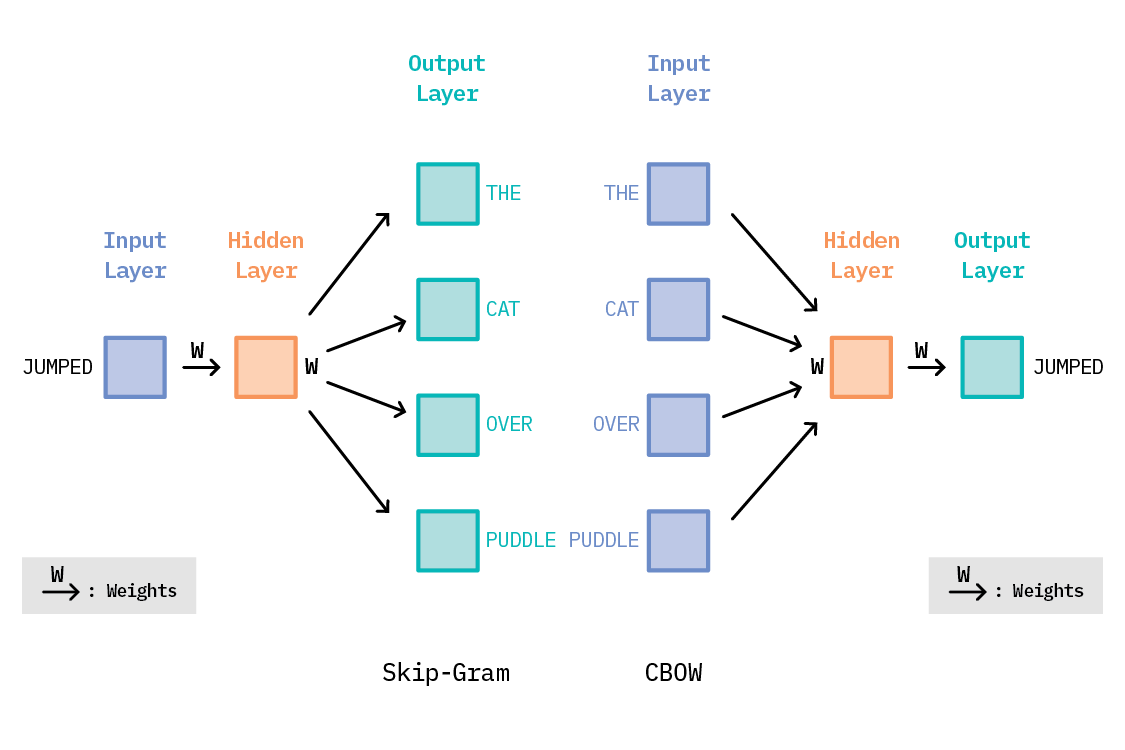

### Word2vec versions: Skip-Gram vs Continuous Bag of Words

Training this shallow network means learning the values of these weight matrices, which gives us the output that is closest to the training data. Once trained, the output layer is usually discarded, and the hidden layer (also known as the embeddings) is used for downstream processes. These embeddings are nothing but vector representations of each word, such that similar words have vector representations that are close together in the embedding space.

```python
def train_w2v(train_data, params:dict, callbacks=None, model_name=None):
    if model_name: 
        # Load a model for additional training. 
        model = Word2Vec.load(model_name)
    else: 
        # train model
        if callbacks:
            model = Word2Vec(callbacks=callbacks, **params)
        else:
            model = Word2Vec(**params)
        model.build_vocab(train_data)

    model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
    vectors = model.wv
    return vectors
```

### How can we use this for NEP?

We can treat each session as a sentence, with each item or product in the session representing a “word.” A website’s collection of user browser histories will act as the corpus. Word2vec will crunch over the entire corpus, learning relationships between products in the context of user browsing behavior. The result will be a collection of embeddings: one for each product. The idea is that these learned product embeddings will contain more information than a simple heuristic, and training the word2vec algorithm is typically faster and easier than training more complex, data-hungry deep learning algorithms.

<!---------------------------->

## Hyperparameter tuning

Duration: 10

In the previous section, we simply trained word2vec using the default hyperparameters-but hyperparameters matter! In addition to the learning rate or the embedding size (hyperparameters likely familiar to many), word2vec has several others which have considerable impact on the resulting embeddings. Let’s see how.

The default word2vec's parameters in Gensim library were found to produce semantically meaningful representations for words in documents, but we are learning embeddings for products in online sessions. The order of products in online sessions will not have the same structure as words in sentences, so we’ll need to consider adjusting word2vec’s hyperparameters to be more appropriate to the task.


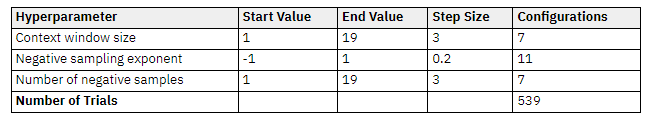

This table shows the main hyperparameters we tuned over. For each one, we show the starting and ending values we tried, along with the step size we used. The total number of trials is computed by multiplying each value in the Configurations column.

We trained a word2vec model using the best hyperparameters found above, which resulted in a Recall@10 score of 25.18±0.19 on the validation set, and 25.21±.26 for the test set. These scores may not seem immediately impressive, but if we consider that there are more than 3600 different products to recommend, this is far better than random chance!

```python
from ray.tune import Analysis
from ray.tune.schedulers import ASHAScheduler

# Define the hyperparameter search space for Word2Vec algorithm
search_space = {
    "dataset": "ecomm",
    "k": 10,
    "size": tune.grid_search(list(np.arange(10,106, 6))),
    "window": tune.grid_search(list(np.arange(1,22, 3))),
    "ns_exponent": tune.grid_search(list(np.arange(-1, 1.2, .2))),
    "alpha": tune.grid_search([0.001, 0.01, 0.1]),
    "negative": tune.grid_search(list(np.arange(1,22, 3))),
    "iter": 10,
    "min_count": 1,
    "workers": 6,
    "sg": 1,
}

use_asha = True
smoke_test = False

# The ASHA Scheduler will stop underperforming trials in a principled fashion
asha_scheduler = ASHAScheduler(max_t=100, grace_period=10) if use_asha else None

# Set the stopping critera -- use the smoke-test arg to test the system 
stopping_criteria = {"training_iteration": 1 if smoke_test else 9999}

# Perform hyperparamter sweep with Ray Tune
analysis = tune.run(
    tune_w2v,
    name=expt_dir,
    local_dir="ray_results",
    metric="recall_at_k",
    mode="max",
    scheduler=asha_scheduler,
    stop=stopping_criteria,
    num_samples=1,
    verbose=1,
    resources_per_trial={
        "cpu": 1,
        "gpu": 0
    },
    config=search_space,
)
print("Best hyperparameters found were: ", analysis.best_config)
```

### **Hyperparameter Tuning with Ray**

There are several libraries that make hyperparameter optimization approachable, easy, and *scalable*. For this cycle, we explored [Ray](https://docs.ray.io/en/master/index.html).

At its core, Ray is a simple, universal API for building distributed applications. Atop this foundation are a handful of libraries designed to address specific machine learning challenges. [Ray Tune](https://docs.ray.io/en/master/tune/index.html) provides several desirable features, including distributed hyperparameter sweep, checkpointing, and state-of-the-art hyperparameter search algorithms—all while supporting most major ML frameworks, such as PyTorch, Tensorflow, and Keras.

In our experiments, we tuned over the hyperparameters in the table above for the number of trials specified. Each trial was trained for 100 epochs and was evaluated on the validation set using Recall@10. This resulted in the best hyperparameter configuration for the Online Retail Data Set.

<!---------------------------->

## Evaluation

Duration: 10

### Evaluation metrics

For a sequence containing n interactions, we use the first (n-1) items in that sequence as part of the model training set. We randomly sample (n-1th, nth) pairs from these sequences for the validation and test sets. For prediction, we use the last item in the training sequence (the n-1th item) as the query item, and predict the K closest items to the query item using cosine similarity between the vector representations. We can then evaluate with the following metrics:

- **Recall at *K* (Recall@*K*)** defined as the proportion of cases in which the ground truth item is among the top *K* recommendations for all test cases (that is, a test example is assigned a score of 1 if the *n*th item appears in the list, and 0 otherwise).
- **Mean Reciprocal Rank at *K* (MRR@*K*)**, takes the average of the reciprocal ranks of the ground truth items within the top *K* recommendations for all test cases (that is, if the *n*th item was second in the list of recommendations, its reciprocal rank would be 1/2). This metric measures and favors higher ranks in the ordered list of recommendation results.

Accuracy, however, is not the only relevant factor when it comes to recommendations. Depending on the problem, we may want to measure how diverse the recommendations are, or if our algorithm generally tends to recommend most popular items. These additional quality metrics, known as coverage (or diversity) and popularity bias, could help us better understand the potential side-effects of the recommender model.

We trained a word2vec model using the best hyperparameters found above, which resulted in a Recall@10 score of 25.18±0.19 on the validation set, and 25.21±.26 for the test set. These scores may not seem immediately impressive, but if we consider that there are more than 3600 different products to recommend, this is far better than random chance!

### Model comparison

Now that we’ve learned the best hyperparameters for our dataset, we can start looking at some model comparisons. We trained models using both our best hyperparameters and the default hyperparameters, each for 100 epochs. The number of epochs is another important parameter, and the default in Gensim’s implementation is five. So we trained another default word2vec model with only five epochs. Finally, we’ve shown the “Association Rules” baseline, a simple heuristic that predicts recommendations based on frequent co-occurrence between items.


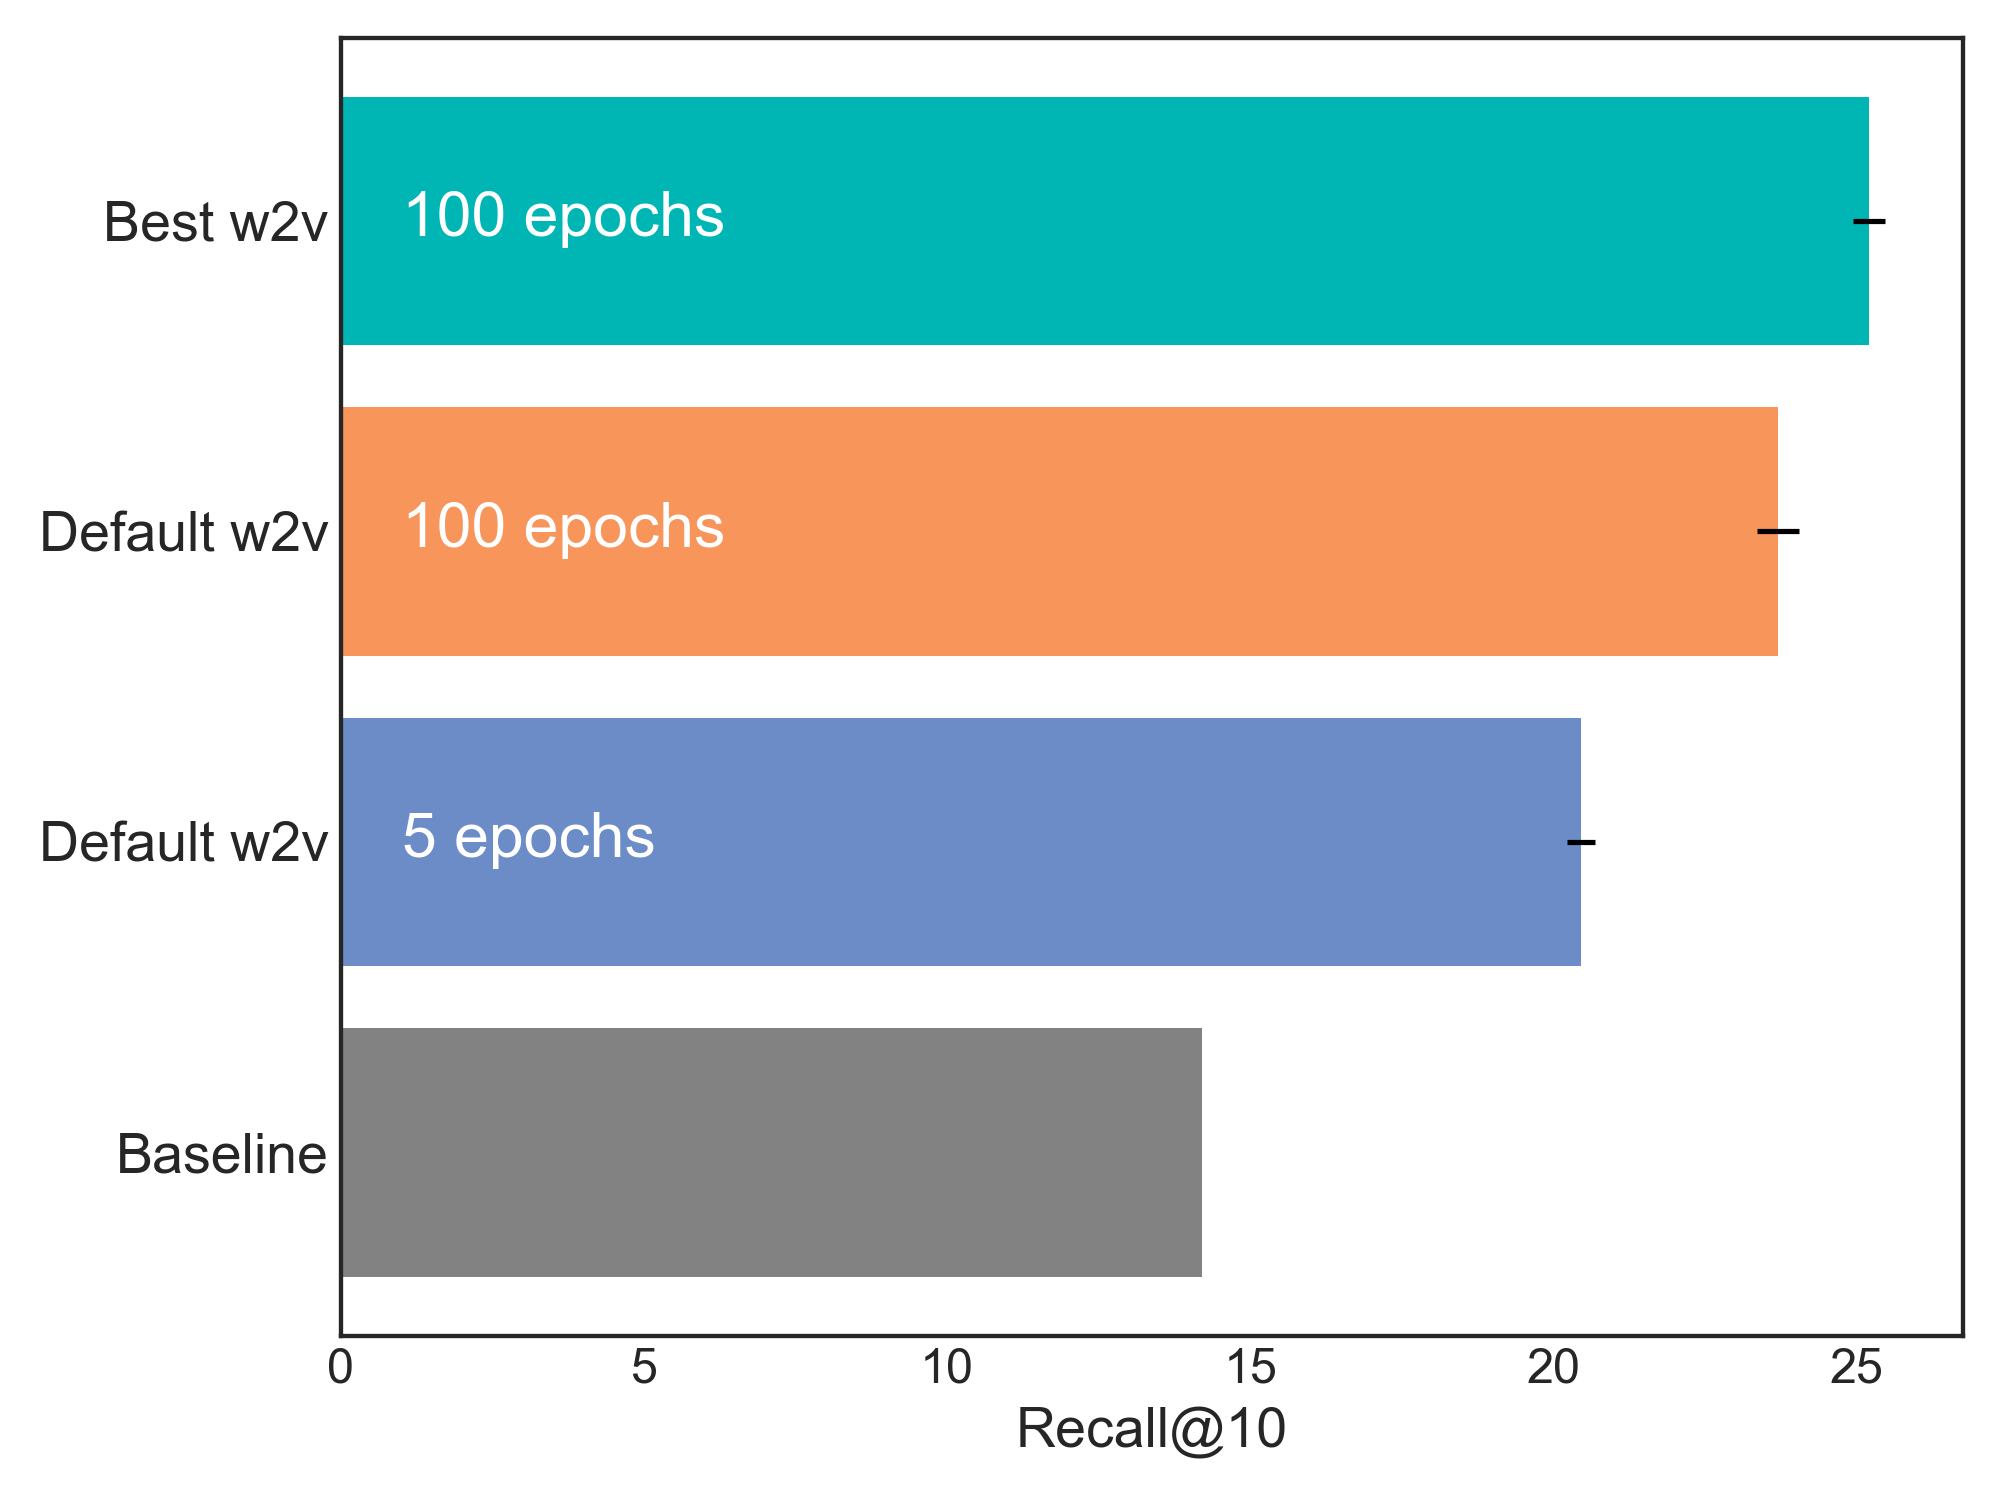

### **Online evaluation**

Offline evaluations rarely inform us about the quality of recommendations **as perceived by the users**. In one study of e-commerce session-based recommenders, it was observed that offline evaluation metrics often fall short because they tend to reward an algorithm when they predict the exact item that the user clicked or purchased. In real life, though, there are identical products that could potentially make equally good recommendations. To overcome these limitations, we suggest incorporating human feedback on the recommendations from offline evaluations before conducting A/B tests.

<!---------------------------->

## Conclusion

Duration: 2

Recommender systems have become a cornerstone of online life; they help us navigate an overwhelming amount of information. Being able to predict a user’s interests based on an online session is a highly relevant problem in practice. There is not, however, a one-size-fits-all model; each solution will ultimately be unique to the use case, and care must, as always, be taken in the development and assessment of the model, in order to provide recommendations that will help users and businesses alike. Careful development and assessment of any machine learning model is critical, but it is especially true with recommender systems in general, and session-based recommenders in particular. The best approach is to first benchmark several options on offline metrics (such as Recall@K), and then perform online evaluation (through A/B testing, for instance), before settling on a given model—as offline metrics typically cannot be used to properly assess real-world KPIs (like revenue generation or watch time).

### What we've covered

- We experimented with an NLP-based algorithm—word2vec—which is known for learning low-dimensional word representations that are contextual in nature.
- We applied it to an e-commerce dataset containing historical purchase transactions, to learn the structure induced by both the user’s behavior and the product’s nature to recommend the next item to be purchased.
- While doing so, we learned that hyperparameter choices are data- and task-dependent, and especially, that they differ from linguistic tasks; what works for language models does not necessarily work for recommendation tasks.
- That said, our experiments indicate that in addition to specific parameters (like negative sampling exponent, the number of negative samples, and context window size), the number of training epochs greatly influences model performance. We recommend that word2vec be trained for as many epochs as computational resources allow, or until performance on a downstream recommendation metric has plateaued.
- We also realized during our experimentation that performing hyperparameter search over just a handful of parameters can be time consuming and computationally expensive; hence, it could be a bottleneck to developing a real-life recommendation solution (with word2vec). While scaling hyperparameter optimization *is* possible through tools like Ray Tune, we envision additional research into algorithmic approaches to solve this problem would pave the way in developing more scalable (and less complex) solutions.

### Next steps

1. Explore and run colab notebook to understand the python implementation process
2. Learn and implement word2vec algorithm
3. Apply the word2vec to build other interesting session-based recommender systems

### Links and References

1. [YouTube. Fast Forward Live: Session-based Recommender Systems.](https://youtu.be/JoRx6udpnbI)
2. [Blog. Session-based Recommender Systems.](https://session-based-recommenders.fastforwardlabs.com/)
3. [GitHub. Session-based Recommender Systems.](https://github.com/fastforwardlabs/session_based_recommenders)